# Parameters

In [46]:
TRACEFILE = "./MsgTraces_W5_load-98p_0.tr"

In [47]:
from typing import Dict, List
from collections import defaultdict

class Message:
    def __init__(self, sender, receiver, txid, sz):
        self.sender = sender
        self.receiver = receiver
        self.key = self.get_key(sender, receiver, txid)

        self.sz = sz
        self.start_ts = 0.0
        self.end_ts = 0.0
    
    @property
    def completion_time(self):
        return self.end_ts - self.start_ts
    
    @staticmethod
    def get_key(sender, receiver, txid):
        return "%s %s\t%s" % (sender, receiver, txid)
    
    def __str__(self):
        return f"{self.key}\t{self.completion_time}"

messages: Dict[str, List[Message]] = defaultdict(lambda: []) 
messages_size2delays: Dict[int, List[float]] = defaultdict(lambda: []) 
messages_allsizes: List[int] = []

with open(TRACEFILE, "r") as f:
    for line in f:
        log = line.split()
        ts = float(log[1])         # nanoseconds
        sz = int(log[2])            # bytes
        sender = log[3]             # ip:port
        receiver = log[4]             # ip:port
        txid = int(log[5])

        key = Message.get_key(sender, receiver, txid)

        if log[0] == "+":
            msg = Message(sender, receiver, txid, sz)
            msg.start_ts = ts
            messages[key].append(msg)
        elif log[0] == "-":
            msg = next((m for m in messages[key] if m.end_ts == 0), None)
            if not msg:
                print("ERROR: cannot find start entry for ", line)
                continue
            
            if msg.end_ts:
                print("Message already has an end_ts!", msg)
                continue
            
            msg.end_ts = ts
            messages_allsizes.append(msg.sz)
            messages_size2delays[msg.sz].append(msg.completion_time)

all_messages_list = []
for msgs in list(messages.values()):
    all_messages_list.extend(msgs)

In [48]:
for msg in all_messages_list:
    print(msg)

10.0.82.1:1082 10.0.30.1:1030	0	26472206.0
10.0.104.1:1104 10.0.119.1:1119	0	3634909.0
10.0.45.1:1045 10.0.126.1:1126	0	33468242.0
10.0.13.1:1013 10.0.87.1:1087	0	62851.0
10.0.21.1:1021 10.0.45.1:1045	0	55926419.0
10.0.107.1:1107 10.0.10.1:1010	0	20816.0
10.0.79.1:1079 10.0.81.1:1081	0	4002.0
10.0.91.1:1091 10.0.63.1:1063	0	50841.0
10.0.16.1:1016 10.0.29.1:1029	0	2057565.0
10.0.10.1:1010 10.0.93.1:1093	0	24419.0
10.0.116.1:1116 10.0.99.1:1099	0	149339.0
10.0.69.1:1069 10.0.5.1:1005	0	14811.0
10.0.48.1:1048 10.0.115.1:1115	0	29223.0
10.0.46.1:1046 10.0.139.1:1139	0	774594.0
10.0.125.1:1125 10.0.98.1:1098	0	2187912.0
10.0.10.1:1010 10.0.72.1:1072	1	553203.0
10.0.57.1:1057 10.0.28.1:1028	0	20816.0
10.0.21.1:1021 10.0.141.1:1141	1	4807310.0
10.0.70.1:1070 10.0.16.1:1016	0	65871.0
10.0.124.1:1124 10.0.138.1:1138	0	7884.0
10.0.25.1:1025 10.0.79.1:1079	0	244203.0
10.0.50.1:1050 10.0.59.1:1059	0	145821.0
10.0.41.1:1041 10.0.112.1:1112	0	79665.0
10.0.87.1:1087 10.0.30.1:1030	0	1574750.0
10.0.23

In [49]:

import numpy as np
from scipy import stats

messages_allsizes = np.array(messages_allsizes)
msg_size_percentiles = stats.rankdata(messages_allsizes, "max")/len(messages_allsizes) * 100


In [50]:
# some basic statistics

print("Total number of messages:", len(all_messages_list))
print("Total number of distinct message sizes:", len(messages_size2delays))

num_incomplete = len([msg for msg in all_messages_list if msg.end_ts == 0])
print("Number of incomplete messages: %s" % num_incomplete)

Total number of messages: 1316
Total number of distinct message sizes: 286
Number of incomplete messages: 0


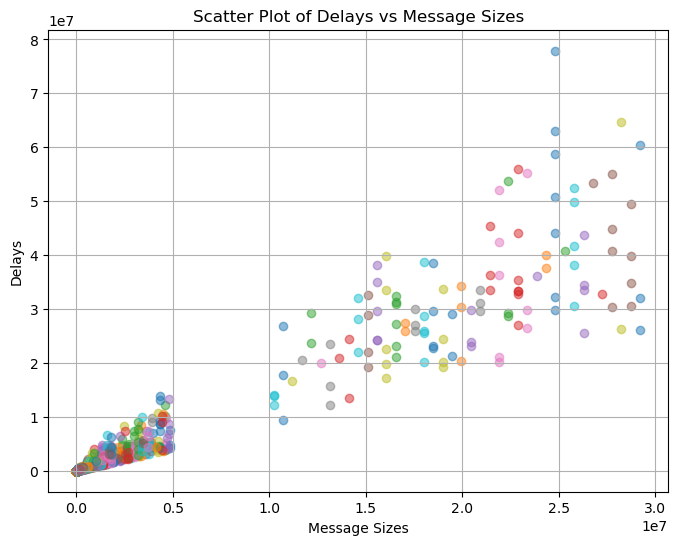

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for message_size, delays in messages_size2delays.items():
    plt.scatter([message_size] * len(delays), delays, label=f'Message Size {message_size}', alpha=0.5)

# plt.xscale('log')

# Set labels and title
plt.xlabel('Message Sizes')
plt.ylabel('Delays')
plt.title('Scatter Plot of Delays vs Message Sizes')

# Show the plot
plt.grid(True)
plt.show()